In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [45]:
df_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Mouna_Loa_Weekly_Data.csv')
df_new.head()

,Year,Month,Day,Year(decimal),CO2(PPM)
0,1974,5,19,1974.3795,333.37
1,1974,5,26,1974.3986,332.95
2,1974,6,2,1974.4178,332.35
3,1974,6,9,1974.4370,332.20
4,1974,6,16,1974.4562,332.37


In [9]:
df_new.tail()

,Year,Month,Day,Year(decimal),CO2(PPM)
2472,2021,10,3,2021.7548,413.63
2473,2021,10,10,2021.7740,413.89
2474,2021,10,17,2021.7932,414.36
2475,2021,10,24,2021.8123,413.90
2476,2021,10,31,2021.8315,414.17


In [10]:
df_new.shape

(2477, 5)

In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           2477 non-null   int64  
 1   Month          2477 non-null   int64  
 2   Day            2477 non-null   int64  
 3   Year(decimal)  2477 non-null   float64
 4   CO2(PPM)       2477 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 96.9 KB


In [46]:
df_new['CO2(PPM)'].min()

-999.99

In [47]:
df_new.replace(-999.99,np.nan,inplace=True)
df = df_new.fillna(df_new.rolling(7,min_periods=1).mean())

In [48]:
df.isnull().sum()

Year             0
Month            0
Day              0
Year(decimal)    0
CO2(PPM)         0
dtype: int64

In [49]:
time = pd.date_range(start='5/19/1974',periods=2477,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Year','Month','Year(decimal)','Day'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [50]:
df.columns=['CO2_PPM']

In [17]:
df.head()

,CO2_PPM
time_stamp,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37


In [18]:
df.tail()

,CO2_PPM
time_stamp,
2021-10-03,413.63
2021-10-10,413.89
2021-10-17,414.36
2021-10-24,413.90
2021-10-31,414.17


In [51]:
plt.rcParams['figure.figsize'] = [15,8]

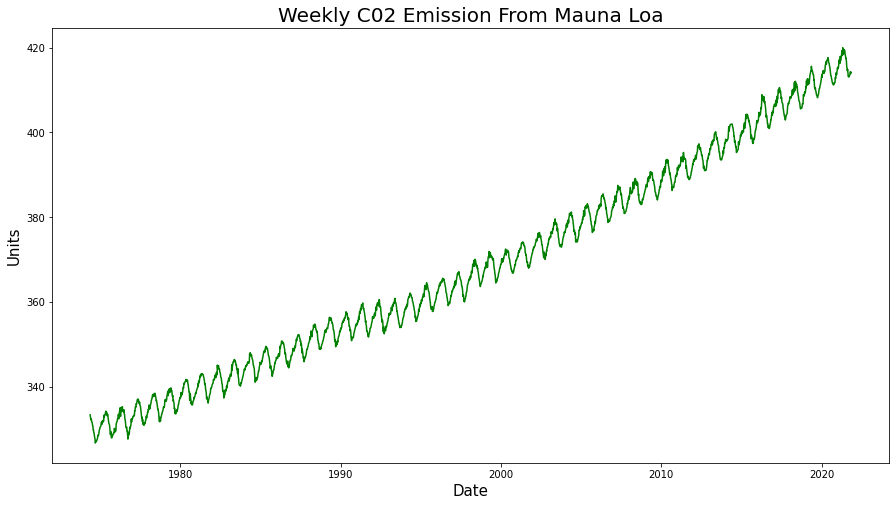

In [22]:
plt.plot(df,color='green')
plt.title('Weekly C02 Emission From Mauna Loa',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [52]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [53]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['CO2_PPM'] = df['CO2_PPM'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [54]:
#Split data set into testing dataset and train dataset
train_size = 2230
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 5
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [26]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2225, 5)
(2225,)
(242, 5)
(242,)


In [27]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 4.5 MB/s 


In [28]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [29]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 64,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [30]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [32]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 35s]
val_mape: 2.2224204540252686

Best val_mape So Far: 0.46881303191185
Total elapsed time: 00h 06m 15s
INFO:tensorflow:Oracle triggered exit


In [33]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout: False
learning_rate: 0.0004581017397685277
Dropout_rate: 0.4
units_1: 8
Score: 0.46881303191185
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
dropout: False
learning_rate: 0.08609990515791306
Dropout_rate: 0.4
units_1: 16
Score: 0.47107285261154175
Trial summary
Hyperparameters:
num_layers: 4
units_0: 24
dropout: False
learning_rate: 0.0014507956460961468
Dropout_rate: 0.2
units_1: 32
units_2: 32
units_3: 16
Score: 0.4728447496891022
Trial summary
Hyperparameters:
num_layers: 2
units_0: 48
dropout: False
learning_rate: 0.006535620815456911
Dropout_rate: 0.4
units_1: 24
Score: 0.47846871614456177
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
dropout: True
learning_rate: 0.00015834362549924747
Dropout_rate: 0.0
Score: 0.5207825899124146
Trial summary
Hyperparameters:
num_layers: 2
units_0: 16

In [34]:
from warnings import filterwarnings
filterwarnings('ignore')

In [35]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 5))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


In [37]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
model = Sequential()
model.add(Dense(8,activation='relu',input_dim = 5))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.00005581017397685277)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 33, epochs = 300,callbacks=[EarlyStopping(monitor='val_loss', patience=40)])

Epoch 1/300
68/68 [==============================] - 1s 4ms/step - loss: 35.4735 - mape: 35.4735 - val_loss: 33.0951 - val_mape: 33.0951
Epoch 2/300
68/68 [==============================] - 0s 2ms/step - loss: 27.7586 - mape: 27.7586 - val_loss: 26.9005 - val_mape: 26.9005
Epoch 3/300
68/68 [==============================] - 0s 2ms/step - loss: 19.9076 - mape: 19.9076 - val_loss: 20.6034 - val_mape: 20.6034
Epoch 4/300
68/68 [==============================] - 0s 2ms/step - loss: 12.6201 - mape: 12.6201 - val_loss: 14.6987 - val_mape: 14.6987
Epoch 5/300
68/68 [==============================] - 0s 2ms/step - loss: 7.8921 - mape: 7.8921 - val_loss: 10.1722 - val_mape: 10.1722
Epoch 6/300
68/68 [==============================] - 0s 2ms/step - loss: 5.8347 - mape: 5.8347 - val_loss: 7.2810 - val_mape: 7.2810
Epoch 7/300
68/68 [==============================] - 0s 2ms/step - loss: 5.0016 - mape: 5.0016 - val_loss: 5.7309 - val_mape: 5.7309
Epoch 8/300
68/68 [==============================] 

In [59]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [60]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.11 
Test MAPE : 0.48 


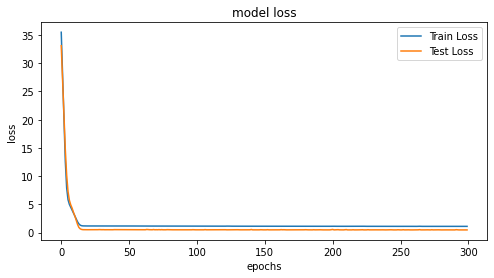

In [61]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [62]:
import seaborn as sns

In [63]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2225,2467)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

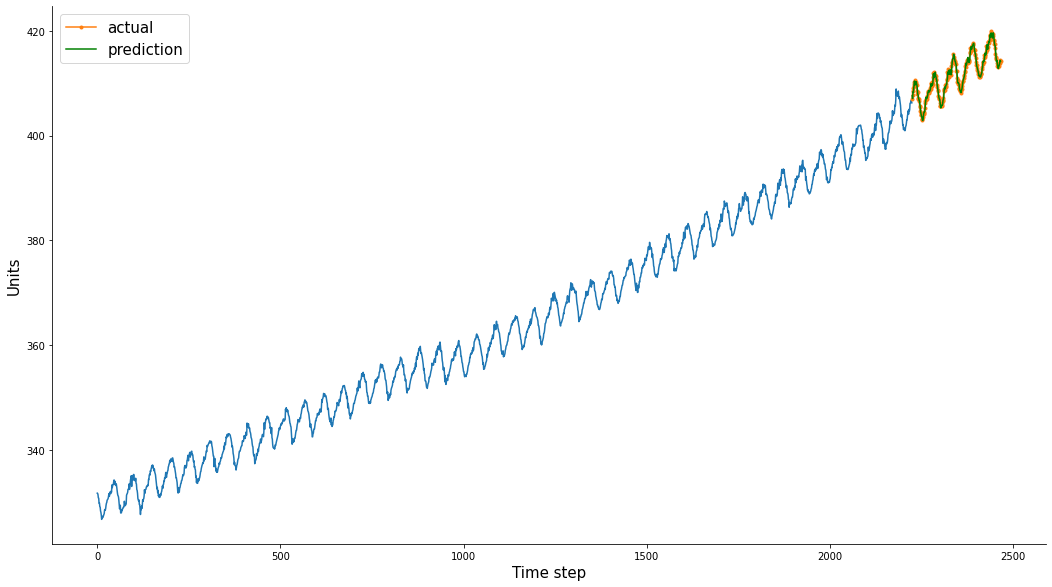

In [64]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)